# YOLO, YOLO PX, YOLO PX II method analysis and final errors for DS-ID
- Code to estimate Gaussians of images 600 to 800 in the database

In [ ]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "model_name": "YOLOv0_E4_detect",
}

In [2]:
# Folders
# Location of images
images_folder = f"docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/"
# Location of labels
labels_folder = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/"

In [3]:
# Path for sample image
n_image = 601
image_path = f"docs/Data/Images/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [4]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [6]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load modules

In [13]:
# Training runs (best)
bst_run = {
    "YOLOv0_detect": "2023-07-26_18-50-24",
    "YOLOv0_E2_detect": "2023-08-21_09-27-11",
    "YOLOv0_E3_detect": "2023-08-21_10-25-30",
    "YOLOv0_E4_detect": "2023-08-21_14-37-58",
    "YOLOv0_E12_detect": "2023-08-21_13-57-46",
    "YOLOv0_T80kenji_detect": "2023-09-04_11-19-43",
}

In [ ]:
# Load custom model
base_path = "docs/Models"
model_path = os.path.join(NOTEBOOK_CONFIG['model_name'], 
                          "runs", 
                          str(bst_run[NOTEBOOK_CONFIG['model_name']]), 
                          NOTEBOOK_CONFIG['task'])

model = YOLO(f"{base_path}/{model_path}/train/weights/best.pt")

In [ ]:
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import parameters_extract, checkpoint_error
from helpers.aux_plotter import (
    plot_boxes,
    plot_boxes_gmm,
    gaussians_labelled,
    plot_grayscale,
    plot_box_labels,
)
from pipelines.pipelines import (
    ppl_fit_gaussians,
    ppl_error_estimation,
    ppl_yolo_predict_gaussians,
    ppl_yolo_px_predict_gaussians,
    ppl_ensemble_predict_gaussians,
)
from helpers.error_estimation import compute_error_per_gaussian

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [15]:
# Load 400 gaussians
mat = scipy.io.loadmat("docs/Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [16]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

# [ESTIMATION PART IV]
- Images: 400 - 599
  -  All amplitudes are higher around 2.1E6 (400%)
  - x center coincides with beta xs
  - y center Coincides with beta ys
  - dispersion in x Higher dispersion in x direction around 0.017 (170%)
  - dispersion in y Higher dispersion in y direction around 0.01 (170%)


## [ESTIMATION] Pipeline ppl_Yolo

### Predict with custom model - YOLOv0

In [24]:
os.listdir("docs/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [25]:
os.listdir("docs/Models/YOLOv0_detect/datasets/test/images/")

['gaussian_738.png',
 'gaussian_777.png',
 'gaussian_650.png',
 'gaussian_772.png',
 'gaussian_703.png',
 'gaussian_704.png',
 'gaussian_726.png',
 'gaussian_710.png',
 'gaussian_601.png',
 'gaussian_622.png',
 'gaussian_664.png',
 'gaussian_694.png',
 'gaussian_690.png',
 'gaussian_700.png',
 'gaussian_605.png',
 'gaussian_719.png',
 'gaussian_614.png',
 'gaussian_603.png',
 'gaussian_766.png',
 'gaussian_714.png']

In [26]:
# Wrap sizes and ranges
image_ranges = [(0, NOTEBOOK_CONFIG["IMG_WIDTH"]), (0, NOTEBOOK_CONFIG["IMG_LENGTH"])]
image_size = [NOTEBOOK_CONFIG["IMG_XDIM"], NOTEBOOK_CONFIG["IMG_YDIM"]]

In [27]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [
    (float(x), float(y))
    for x, y in zip(
        results[0].boxes.xywhn[:, 0] * image_size[0],
        results[0].boxes.xywhn[:, 1] * image_size[1],
    )
]


0: 640x256 77 gaussians, 635.7ms
Speed: 17.2ms preprocess, 635.7ms inference, 36.5ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(15, 20))

# Display the image and plot predicted centers
ax.imshow(im)
plot_boxes(tensor_boxes, ax, edge_color="g")
ax.set_ylim(ax.get_ylim()[::-1])
ax.scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[2].axis('off')
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

plt.show()

In [ ]:
# Estimate Gaussian - Final prediction
image = [x, y, mat["F_data"][:, :, n_image]]
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=image_ranges,
    image_size=image_size,
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

Number of indentifiable Gaussians (center in the image): 76


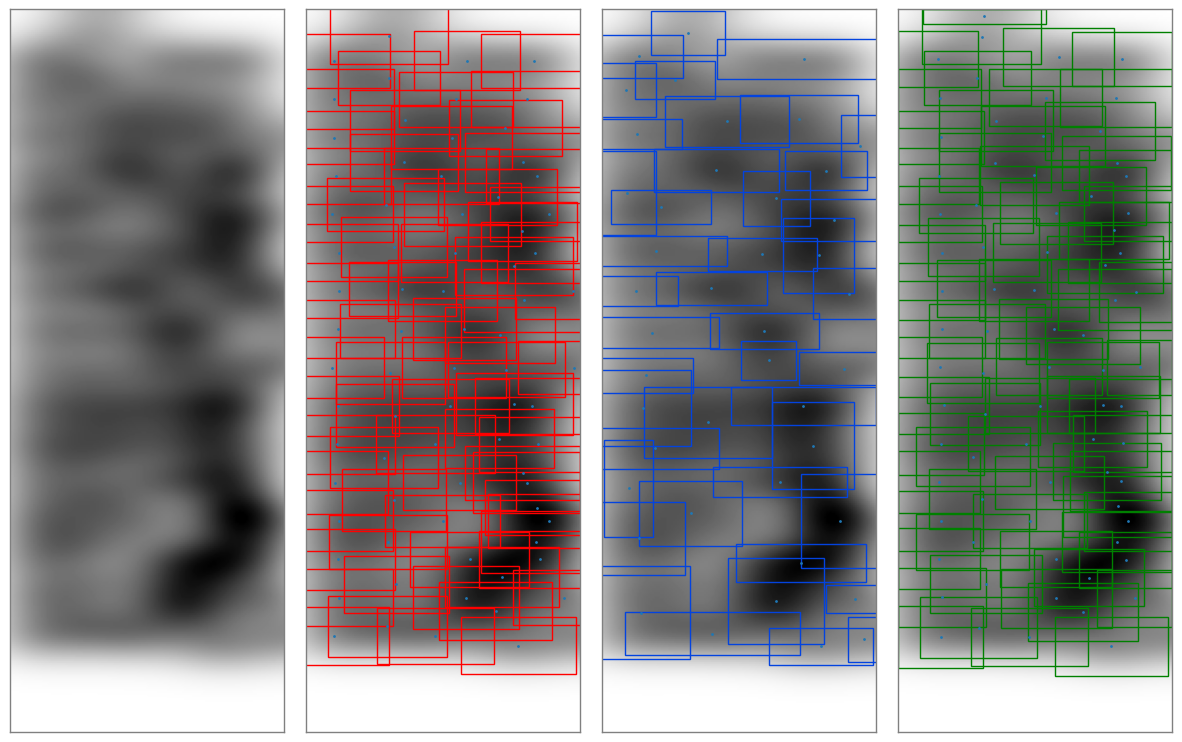

In [28]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize=(15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(
    means=means, covariances=covariances, ax=axs[2], beta=3, edge_color="#0343DF"
)
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:, 0] * 1000, means[:, 1] * 1000, s=1)
# axs[3].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes, axs[3], edge_color="g")
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[2].axis('off')
axs[3].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[3].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO": [],
    "Number identifiable - YOLO": [],
    "Percentage - YOLO": [],
    "RMSE_cx - YOLO": [],
    "RMSE_cy - YOLO": [],
    "RMSE_c - YOLO": [],
    "RMSE_sigmax - YOLO": [],
    "RMSE_sigmay - YOLO": [],
    "RMSE_sigma - YOLO": [],
    "MaxE_sigmax - YOLO": [],
    "MaxE_sigmay - YOLO": [],
    "MaxE_sigma - YOLO": [],
    "RMSE_amplitude - YOLO": [],
    "RMSEPixel - YOLO": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO",
        image_path="docs/Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 218.9ms
Speed: 1.4ms preprocess, 218.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027097           0]
  [          0    0.013563]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 193.2ms
Speed: 1.7ms preprocess, 193.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027385           0]
  [          0    0.014418]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 176.0ms
Speed: 1.7ms preprocess, 176.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028106           0]
  [          0    0.014089]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 178.9ms
Speed: 1.3ms preprocess, 178.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027477           0]
  [          0    0.014942]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 251.9ms
Speed: 2.2ms preprocess, 251.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019863           0]
  [          0    0.013598]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 276.1ms
Speed: 1.3ms preprocess, 276.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022204           0]
  [          0    0.014646]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 246.4ms
Speed: 1.3ms preprocess, 246.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029166           0]
  [          0    0.014775]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 242.3ms
Speed: 1.4ms preprocess, 242.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021174           0]
  [          0    0.013209]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 177.1ms
Speed: 1.7ms preprocess, 177.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021093           0]
  [          0    0.013115]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 179.1ms
Speed: 2.0ms preprocess, 179.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021547           0]
  [          0     0.01341]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 183.1ms
Speed: 1.5ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021494           0]
  [          0    0.013726]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 179.2ms
Speed: 1.4ms preprocess, 179.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020683           0]
  [          0    0.014477]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 173.4ms
Speed: 1.1ms preprocess, 173.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020754           0]
  [          0    0.014394]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 185.6ms
Speed: 1.6ms preprocess, 185.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020411           0]
  [          0    0.013768]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 187.4ms
Speed: 1.4ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020054           0]
  [          0    0.014909]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 177.5ms
Speed: 1.4ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020998           0]
  [          0    0.015582]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 178.1ms
Speed: 2.2ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.026662           0]
  [          0    0.014155]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 179.6ms
Speed: 1.9ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021479           0]
  [          0    0.015493]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 178.3ms
Speed: 1.7ms preprocess, 178.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028559           0]
  [          0    0.014599]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 173.9ms
Speed: 3.1ms preprocess, 173.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022105           0]
  [          0    0.014874]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,688.60,56.81,777.00
Number identified - YOLO,78.85,1.50,81.00
Number identifiable - YOLO,75.30,1.42,77.00
Percentage - YOLO,104.74,2.27,108.11
RMSE_cx - YOLO,11.71,0.59,13.22
RMSE_cy - YOLO,0.35,0.22,1.28
RMSE_c - YOLO,11.71,0.60,13.28
RMSE_sigmax - YOLO,12.40,0.79,13.61
RMSE_sigmay - YOLO,3.85,0.42,5.27
RMSE_sigma - YOLO,12.99,0.71,14.14


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - YOLO,Number identifiable - YOLO,Percentage - YOLO,RMSE_cx - YOLO,RMSE_cy - YOLO,RMSE_c - YOLO,RMSE_sigmax - YOLO,RMSE_sigmay - YOLO,RMSE_sigma - YOLO,MaxE_sigmax - YOLO,MaxE_sigmay - YOLO,MaxE_sigma - YOLO,RMSE_amplitude - YOLO,RMSEPixel - YOLO
8,601,77,76,101.32,10.67,0.28,10.68,10.41,4.03,11.16,41.76,75.94,86.67,108.37,6008307.31
17,603,80,77,103.90,11.30,0.27,11.30,12.63,3.19,13.03,58.06,75.45,95.21,100.82,5570945.13
14,605,79,76,103.95,11.35,0.41,11.36,11.64,3.90,12.28,54.52,77.81,95.01,105.48,5869703.88
16,614,78,77,101.30,11.36,0.34,11.37,11.60,3.64,12.16,49.50,75.21,90.04,105.26,5855334.98
9,622,80,76,105.26,12.33,0.28,12.33,13.45,3.44,13.88,52.48,72.88,89.81,104.01,5917142.38
2,650,79,74,106.76,11.72,0.27,11.72,13.61,3.84,14.14,54.65,71.64,90.10,92.46,5025653.99
10,664,78,73,106.85,11.80,0.25,11.81,12.82,3.71,13.34,55.12,75.02,93.09,102.71,5759457.83
12,690,75,75,100.00,12.23,0.30,12.24,11.69,4.01,12.36,46.33,73.27,86.69,104.18,5500650.62
11,694,78,74,105.41,12.49,0.25,12.50,12.53,3.84,13.10,54.97,79.40,96.57,99.29,5782610.19
13,700,81,77,105.19,11.50,0.31,11.50,12.54,4.22,13.23,50.73,76.12,91.48,102.17,5615122.31


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E4YOLO",
)

## [ESTIMATION] Pipeline ppl_SCIKIT_PX - PX Modified
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [ ]:
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Predict Yolo
(means, covariances, amplitudes_yolo) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)


0: 640x256 81 gaussians, 197.5ms
Speed: 1.1ms preprocess, 197.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means,
    new_covariances,
    amplitudes_px,
    new_means,
    new_covariances_up,
    new_covariances_down,
) = ppl_yolo_px_predict_gaussians(mat, n_image, model, image_path, px_step_size=3)


0: 640x256 81 gaussians, 282.9ms
Speed: 3.4ms preprocess, 282.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means_infer,
    new_covariances_infer,
    amplitudes_px_infer,
    new_means_infer,
    new_covariances_up_infer,
    new_covariances_down_infer,
) = ppl_yolo_px_predict_gaussians(
    mat, n_image, model, image_path, px_step_size=3, infer_overlapping=True
)


0: 640x256 81 gaussians, 297.4ms
Speed: 1.5ms preprocess, 297.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize=(25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat["F_data"][:, :, n_image], colorbar=False, ax=ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(
    image,
    [(x, y) for x, y in converted_new_means],
    [
        (wx, wy)
        for wx, wy in zip(
            np.sqrt(new_covariances[:, 0, 0]), np.sqrt(new_covariances[:, 1, 1])
        )
    ],
    ax=ax,
    center_color="b",  # CENTER COLOR
    annotate_gaussians=True,
    text_color="blue",
)

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(
    image,
    list(zip(xs, ys)),
    list(zip(dispersion_x, dispersion_y)),
    ax=ax,
    box_edge_color="g",  # BOX COLOR
    center_color="g",  # CENTER COLOR
    annotate_gaussians=True,
)

In [ ]:
# Plot box and center - YOLO
# Predict
(means, covariances, amplitudes) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)

# Plot box and center
plot_box_labels(
    image,
    [(x, y) for x, y in means],
    [
        (wx, wy)
        for wx, wy in zip(np.sqrt(covariances[:, 0, 0]), np.sqrt(covariances[:, 1, 1]))
    ],
    ax=ax,
    box_edge_color="b",  # BOX COLOR
    center_color="red",  # CENTER COLOR
    annotate_gaussians=False,
)


0: 640x256 81 gaussians, 200.5ms
Speed: 1.7ms preprocess, 200.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])

In [ ]:
adjust_text(all_texts)

62

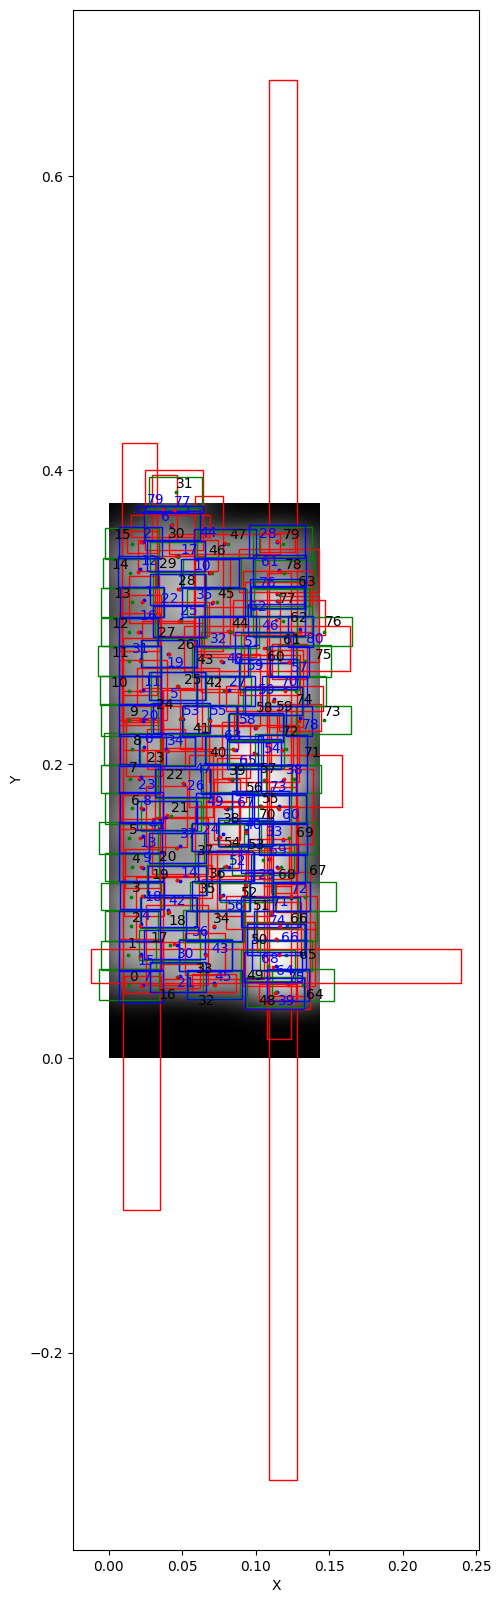

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO_px": [],
    "Number identifiable - YOLO_px": [],
    "Percentage - YOLO_px": [],
    "RMSE_cx - YOLO_px": [],
    "RMSE_cy - YOLO_px": [],
    "RMSE_c - YOLO_px": [],
    "RMSE_sigmax - YOLO_px": [],
    "RMSE_sigmay - YOLO_px": [],
    "RMSE_sigma - YOLO_px": [],
    "MaxE_sigmax - YOLO_px": [],
    "MaxE_sigmay - YOLO_px": [],
    "MaxE_sigma - YOLO_px": [],
    "RMSE_amplitude - YOLO_px": [],
    "RMSEPixel - YOLO_px": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO_px",
        image_path="docs/Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 216.8ms
Speed: 1.6ms preprocess, 216.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.11667           0]
  [          0    0.021301]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 190.1ms
Speed: 2.9ms preprocess, 190.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015966           0]
  [          0    0.015043]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 248.3ms
Speed: 1.5ms preprocess, 248.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017858           0]
  [          0    0.026967]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 248.7ms
Speed: 1.3ms preprocess, 248.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012408           0]
  [          0   0.0097907]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 255.2ms
Speed: 1.6ms preprocess, 255.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01852           0]
  [          0    0.055742]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 513.4ms
Speed: 7.8ms preprocess, 513.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015199           0]
  [          0   0.0095993]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 264.6ms
Speed: 1.2ms preprocess, 264.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027856           0]
  [          0    0.016731]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 312.2ms
Speed: 1.7ms preprocess, 312.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017788           0]
  [          0    0.022437]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 243.6ms
Speed: 1.2ms preprocess, 243.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019243           0]
  [          0    0.040063]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 253.5ms
Speed: 1.2ms preprocess, 253.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01608           0]
  [          0    0.037664]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 240.1ms
Speed: 1.3ms preprocess, 240.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018449           0]
  [          0    0.020171]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 246.1ms
Speed: 1.2ms preprocess, 246.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.021656           0]
  [          0    0.032287]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 245.0ms
Speed: 1.2ms preprocess, 245.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015775           0]
  [          0    0.020624]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 196.5ms
Speed: 1.3ms preprocess, 196.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021978           0]
  [          0    0.051392]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 187.4ms
Speed: 1.2ms preprocess, 187.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024401           0]
  [          0     0.15384]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 187.1ms
Speed: 2.3ms preprocess, 187.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015331           0]
  [          0    0.010483]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 180.2ms
Speed: 1.4ms preprocess, 180.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012427           0]
  [          0    0.010436]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 189.9ms
Speed: 1.6ms preprocess, 189.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018056           0]
  [          0   0.0081103]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 194.5ms
Speed: 1.1ms preprocess, 194.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020495           0]
  [          0    0.031231]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 187.8ms
Speed: 1.3ms preprocess, 187.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01821           0]
  [          0   0.0083593]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,688.60,56.81,777.00
Number identified - YOLO_px,78.85,1.50,81.00
Number identifiable - YOLO_px,75.30,1.42,77.00
Percentage - YOLO_px,104.74,2.27,108.11
RMSE_cx - YOLO_px,13.35,0.66,15.02
RMSE_cy - YOLO_px,0.70,0.24,1.71
RMSE_c - YOLO_px,13.37,0.67,15.11
RMSE_sigmax - YOLO_px,46.03,8.33,72.97
RMSE_sigmay - YOLO_px,106.55,29.76,204.02
RMSE_sigma - YOLO_px,116.63,28.61,209.17


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E4YOLOPX",
)

## Evaluate - Plot Truth, YOLO and PX infer - PX Moodified 2

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize=(25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat["F_data"][:, :, n_image], colorbar=False, ax=ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(
    image,
    [(x, y) for x, y in converted_new_means_infer],
    [
        (wx, wy)
        for wx, wy in zip(
            np.sqrt(new_covariances_infer[:, 0, 0]),
            np.sqrt(new_covariances_infer[:, 1, 1]),
        )
    ],
    ax=ax,
    center_color="b",  # CENTER COLOR
    annotate_gaussians=True,
    text_color="blue",
)

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(
    image,
    list(zip(xs, ys)),
    list(zip(dispersion_x, dispersion_y)),
    ax=ax,
    box_edge_color="g",  # BOX COLOR
    center_color="g",  # CENTER COLOR
    annotate_gaussians=True,
)

In [ ]:
# Plot box and center -  YOLO
plot_box_labels(
    image,
    [(x, y) for x, y in means],
    [
        (wx, wy)
        for wx, wy in zip(np.sqrt(covariances[:, 0, 0]), np.sqrt(covariances[:, 1, 1]))
    ],
    ax=ax,
    box_edge_color="b",  # BOX COLOR
    center_color="red",  # CENTER COLOR
    annotate_gaussians=False,
)

In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])

In [ ]:
adjust_text(all_texts)

6

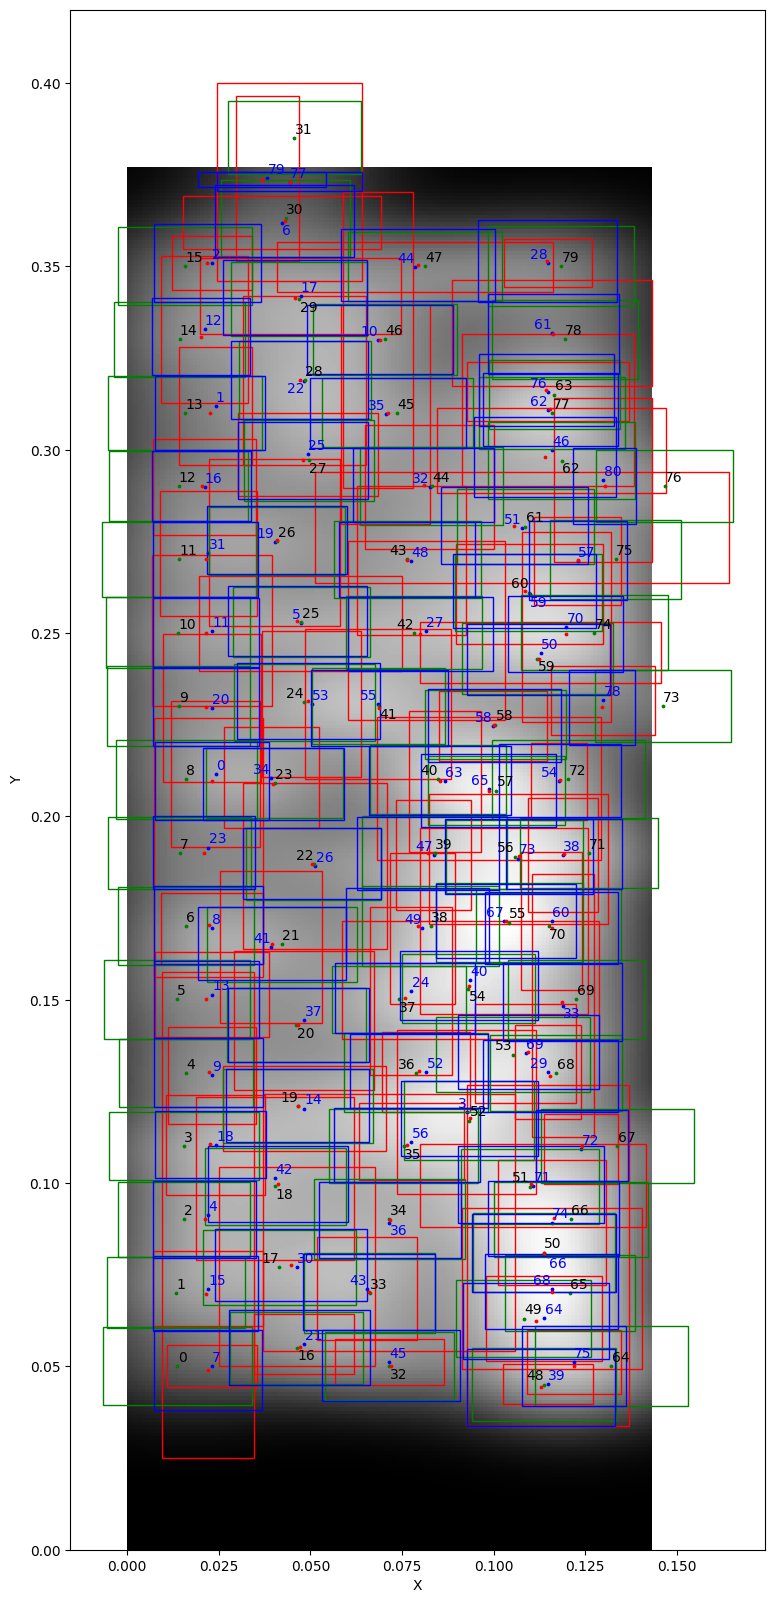

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX Infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO_px_infer": [],
    "Number identifiable - YOLO_px_infer": [],
    "Percentage - YOLO_px_infer": [],
    "RMSE_cx - YOLO_px_infer": [],
    "RMSE_cy - YOLO_px_infer": [],
    "RMSE_c - YOLO_px_infer": [],
    "RMSE_sigmax - YOLO_px_infer": [],
    "RMSE_sigmay - YOLO_px_infer": [],
    "RMSE_sigma - YOLO_px_infer": [],
    "MaxE_sigmax - YOLO_px_infer": [],
    "MaxE_sigmay - YOLO_px_infer": [],
    "MaxE_sigma - YOLO_px_infer": [],
    "RMSE_amplitude - YOLO_px_infer": [],
    "RMSEPixel - YOLO_px_infer": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO_px_infer",
        image_path="docs/Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 204.8ms
Speed: 2.2ms preprocess, 204.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.11667           0]
  [          0    0.021301]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 179.5ms
Speed: 1.5ms preprocess, 179.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015966           0]
  [          0    0.015043]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 181.5ms
Speed: 1.3ms preprocess, 181.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017858           0]
  [          0    0.026967]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 179.7ms
Speed: 2.0ms preprocess, 179.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012408           0]
  [          0   0.0097907]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 181.7ms
Speed: 1.4ms preprocess, 181.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01852           0]
  [          0    0.055742]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 191.0ms
Speed: 1.6ms preprocess, 191.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015199           0]
  [          0   0.0095993]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 191.2ms
Speed: 1.2ms preprocess, 191.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027856           0]
  [          0    0.016731]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 180.9ms
Speed: 2.1ms preprocess, 180.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017788           0]
  [          0    0.022437]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 254.1ms
Speed: 2.6ms preprocess, 254.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019243           0]
  [          0    0.040063]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 282.8ms
Speed: 1.7ms preprocess, 282.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01608           0]
  [          0    0.037664]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 248.6ms
Speed: 1.9ms preprocess, 248.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018449           0]
  [          0    0.020171]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 266.2ms
Speed: 1.4ms preprocess, 266.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.021656           0]
  [          0    0.032287]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 259.9ms
Speed: 3.9ms preprocess, 259.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015775           0]
  [          0    0.020624]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 291.9ms
Speed: 1.1ms preprocess, 291.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021978           0]
  [          0    0.051392]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 277.2ms
Speed: 1.3ms preprocess, 277.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024401           0]
  [          0     0.15384]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 876.0ms
Speed: 1.4ms preprocess, 876.0ms inference, 13.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015331           0]
  [          0    0.010483]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 300.4ms
Speed: 1.4ms preprocess, 300.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012427           0]
  [          0    0.010436]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 273.2ms
Speed: 1.4ms preprocess, 273.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018056           0]
  [          0   0.0081103]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 305.6ms
Speed: 1.4ms preprocess, 305.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020495           0]
  [          0    0.031231]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 262.4ms
Speed: 1.5ms preprocess, 262.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01821           0]
  [          0   0.0083593]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,688.60,56.81,777.00
Number identified - YOLO_px_infer,78.85,1.50,81.00
Number identifiable - YOLO_px_infer,75.30,1.42,77.00
Percentage - YOLO_px_infer,104.74,2.27,108.11
RMSE_cx - YOLO_px_infer,13.35,0.66,15.02
RMSE_cy - YOLO_px_infer,0.70,0.24,1.71
RMSE_c - YOLO_px_infer,13.37,0.67,15.11
RMSE_sigmax - YOLO_px_infer,39.05,4.48,53.27
RMSE_sigmay - YOLO_px_infer,80.30,12.75,106.17
RMSE_sigma - YOLO_px_infer,89.49,12.07,118.79


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E4YOLOPXINFER",
)

## [ESTIMATION] Pipeline ensembled (PX modified 2 and YOLO)

In [ ]:
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [
    np.array([[(wx / (np.sqrt(2))) ** 2, 0], [0, (wy / (np.sqrt(2))) ** 2]])
    for wx, wy in zip(dispersion_x, dispersion_y)
]
amplitudes_truth = amplitude
(
    all_gaussians_truth,
    generated_z_truth,
    rmsep_truth,
    error_gaussians_truth,
) = compute_error_per_gaussian(image, means_truth, covariances_truth, amplitudes_truth)

Gaussian 31 center is out of bounds
Gaussian 73 center is out of bounds
Gaussian 76 center is out of bounds


In [ ]:
# Compute YOLO
(
    all_gaussians_yolo,
    generated_z_yolo,
    rmsep_yolo,
    error_gaussians_yolo,
) = compute_error_per_gaussian(image, means, list(covariances / 2), amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(
    all_gaussians_px,
    generated_z_px,
    rmsep_px,
    error_gaussians_px,
) = compute_error_per_gaussian(
    image, converted_new_means, list(new_covariances / 2), amplitudes_px
)

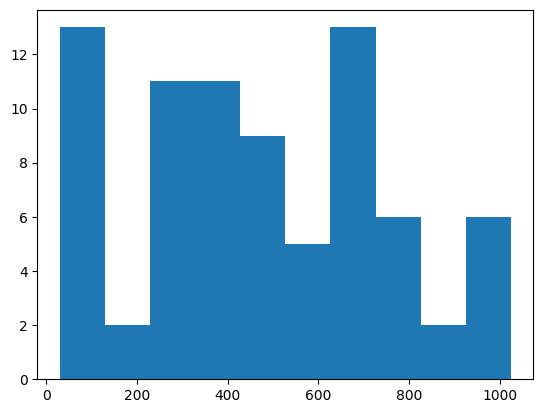

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


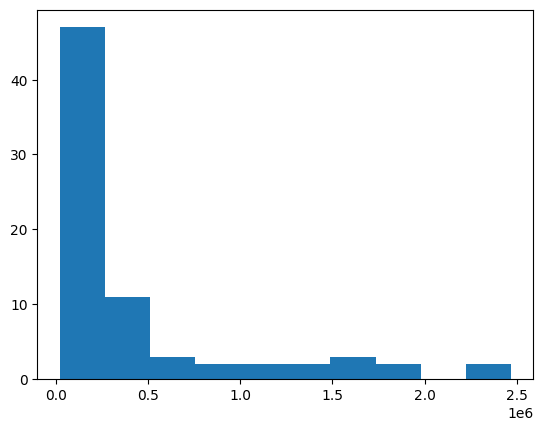

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f"Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}")
print(f"Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}")

Max error gaussian = 70
Min error gaussian = 27


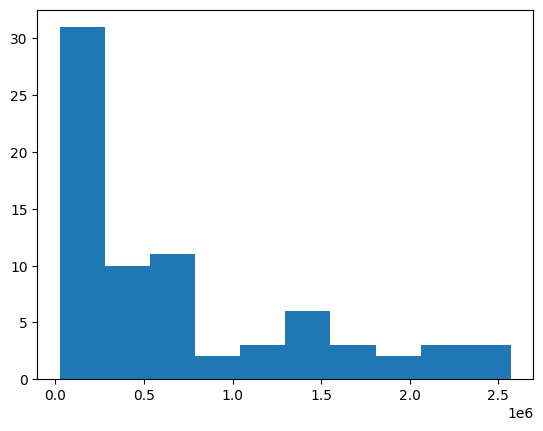

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f"Max error gaussian = {np.argmax(np.array(error_gaussians_px))}")
print(f"Min error gaussian = {np.argmin(np.array(error_gaussians_px))}")

### Error evaluation ensemble Yolo and PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Iterate all images - ensembled method
results = {
    "Image": [],
    "Number identified - ensembled": [],
    "Number identifiable - ensembled": [],
    "Percentage - ensembled": [],
    "RMSE_cx - ensembled": [],
    "RMSE_cy - ensembled": [],
    "RMSE_c - ensembled": [],
    "RMSE_sigmax - ensembled": [],
    "RMSE_sigmay - ensembled": [],
    "RMSE_sigma - ensembled": [],
    "MaxE_sigmax - ensembled": [],
    "MaxE_sigmay - ensembled": [],
    "MaxE_sigma - ensembled": [],
    "RMSE_amplitude - ensembled": [],
    "RMSEPixel - ensembled": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        image_path="docs/Data/Images/",
        peak_method="laplace",
        yolo_model=model,
        estimation_method=["YOLO", "YOLO_px"],
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 226.0ms
Speed: 1.6ms preprocess, 226.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 175.6ms
Speed: 3.2ms preprocess, 175.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027097           0]
  [          0    0.013563]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 181.6ms
Speed: 1.2ms preprocess, 181.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 179.1ms
Speed: 1.5ms preprocess, 179.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027385           0]
  [          0    0.014418]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 176.7ms
Speed: 3.1ms preprocess, 176.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 183.8ms
Speed: 1.2ms preprocess, 183.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028106           0]
  [          0    0.014089]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 170.2ms
Speed: 1.8ms preprocess, 170.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 182.4ms
Speed: 1.0ms preprocess, 182.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027477           0]
  [          0    0.014942]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 174.0ms
Speed: 2.6ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 179.0ms
Speed: 1.3ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019863           0]
  [          0    0.013598]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 179.6ms
Speed: 3.0ms preprocess, 179.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 176.6ms
Speed: 1.3ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.022204           0]
  [          0    0.014646]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 181.0ms
Speed: 3.6ms preprocess, 181.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 177.7ms
Speed: 2.2ms preprocess, 177.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029166           0]
  [          0    0.014775]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 237.4ms
Speed: 1.1ms preprocess, 237.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 264.4ms
Speed: 1.6ms preprocess, 264.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021174           0]
  [          0    0.013209]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 249.2ms
Speed: 1.3ms preprocess, 249.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 251.7ms
Speed: 1.4ms preprocess, 251.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021093           0]
  [          0    0.013115]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 235.1ms
Speed: 1.2ms preprocess, 235.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 182.2ms
Speed: 1.6ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021547           0]
  [          0     0.01341]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 185.0ms
Speed: 0.9ms preprocess, 185.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 176.6ms
Speed: 1.8ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021494           0]
  [          0    0.013726]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 178.5ms
Speed: 2.7ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 180.8ms
Speed: 4.4ms preprocess, 180.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020683           0]
  [          0    0.014477]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 174.8ms
Speed: 2.5ms preprocess, 174.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 181.5ms
Speed: 3.0ms preprocess, 181.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020754           0]
  [          0    0.014394]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 178.1ms
Speed: 1.5ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 175.0ms
Speed: 1.2ms preprocess, 175.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020411           0]
  [          0    0.013768]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 173.1ms
Speed: 1.2ms preprocess, 173.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 185.0ms
Speed: 1.2ms preprocess, 185.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020054           0]
  [          0    0.014909]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 174.6ms
Speed: 1.2ms preprocess, 174.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 179.0ms
Speed: 1.2ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020998           0]
  [          0    0.015582]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 175.0ms
Speed: 1.7ms preprocess, 175.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 175.1ms
Speed: 1.5ms preprocess, 175.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.026662           0]
  [          0    0.014155]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 173.7ms
Speed: 1.5ms preprocess, 173.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 172.5ms
Speed: 1.3ms preprocess, 172.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021479           0]
  [          0    0.015493]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 259.6ms
Speed: 1.9ms preprocess, 259.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 246.9ms
Speed: 1.3ms preprocess, 246.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.028559           0]
  [          0    0.014599]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 241.5ms
Speed: 1.2ms preprocess, 241.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 245.9ms
Speed: 1.4ms preprocess, 245.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022105           0]
  [          0    0.014874]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,688.60,56.81,777.00
Number identified - ensembled,78.85,1.50,81.00
Number identifiable - ensembled,75.30,1.42,77.00
Percentage - ensembled,104.74,2.27,108.11
RMSE_cx - ensembled,11.71,0.59,13.22
RMSE_cy - ensembled,0.35,0.22,1.28
RMSE_c - ensembled,11.72,0.60,13.28
RMSE_sigmax - ensembled,12.45,0.80,13.80
RMSE_sigmay - ensembled,3.95,0.48,5.27
RMSE_sigma - ensembled,13.08,0.74,14.58


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
8,601,77,76,101.32,10.67,0.28,10.68,10.41,4.03,11.16,41.76,75.94,86.67,108.37,6008307.31
17,603,80,77,103.90,11.30,0.27,11.30,12.63,3.19,13.03,58.06,75.45,95.21,100.82,5570945.13
14,605,79,76,103.95,11.35,0.41,11.36,11.64,3.90,12.28,54.52,77.81,95.01,105.48,5869703.88
16,614,78,77,101.30,11.36,0.34,11.37,11.60,3.64,12.16,49.50,75.21,90.04,105.26,5855334.98
9,622,80,76,105.26,12.33,0.28,12.33,13.45,3.44,13.88,52.48,72.88,89.81,104.01,5917142.38
2,650,79,74,106.76,11.72,0.27,11.72,13.61,3.84,14.14,54.65,71.64,90.10,92.46,5025653.99
10,664,78,73,106.85,11.80,0.25,11.81,12.82,3.71,13.34,55.12,75.02,93.09,102.71,5759457.83
12,690,75,75,100.00,12.24,0.27,12.24,12.30,4.54,13.11,51.21,73.27,89.39,104.32,5485714.83
11,694,78,74,105.41,12.49,0.25,12.50,12.53,3.84,13.10,54.97,79.40,96.57,99.29,5782610.19
13,700,81,77,105.19,11.50,0.31,11.50,12.54,4.22,13.23,50.73,76.12,91.48,102.17,5615122.31


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E4YOLOENSEBPX",
)

### Error evaluation ensemble Yolo and PX Modiefied 2

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Iterate all images - ensembled method
results = {
    "Image": [],
    "Number identified - ensembled": [],
    "Number identifiable - ensembled": [],
    "Percentage - ensembled": [],
    "RMSE_cx - ensembled": [],
    "RMSE_cy - ensembled": [],
    "RMSE_c - ensembled": [],
    "RMSE_sigmax - ensembled": [],
    "RMSE_sigmay - ensembled": [],
    "RMSE_sigma - ensembled": [],
    "MaxE_sigmax - ensembled": [],
    "MaxE_sigmay - ensembled": [],
    "MaxE_sigma - ensembled": [],
    "RMSE_amplitude - ensembled": [],
    "RMSEPixel - ensembled": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        image_path="docs/Data/Images/",
        peak_method="laplace",
        yolo_model=model,
        estimation_method=["YOLO", "YOLO_px_infer"],
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 189.1ms
Speed: 1.6ms preprocess, 189.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 178.7ms
Speed: 1.6ms preprocess, 178.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027097           0]
  [          0    0.013563]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 176.7ms
Speed: 1.1ms preprocess, 176.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 190.6ms
Speed: 1.5ms preprocess, 190.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027385           0]
  [          0    0.014418]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 203.2ms
Speed: 1.4ms preprocess, 203.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 187.2ms
Speed: 1.3ms preprocess, 187.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028106           0]
  [          0    0.014089]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 175.6ms
Speed: 1.1ms preprocess, 175.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 185.9ms
Speed: 1.1ms preprocess, 185.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027477           0]
  [          0    0.014942]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 252.7ms
Speed: 2.0ms preprocess, 252.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 518.3ms
Speed: 1.3ms preprocess, 518.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019863           0]
  [          0    0.013598]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 431.2ms
Speed: 1.3ms preprocess, 431.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 263.9ms
Speed: 1.9ms preprocess, 263.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.022204           0]
  [          0    0.014646]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 493.9ms
Speed: 7.4ms preprocess, 493.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 560.2ms
Speed: 8.7ms preprocess, 560.2ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029166           0]
  [          0    0.014775]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 252.4ms
Speed: 1.6ms preprocess, 252.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 258.1ms
Speed: 1.5ms preprocess, 258.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021174           0]
  [          0    0.013209]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 179.8ms
Speed: 1.9ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 182.1ms
Speed: 2.3ms preprocess, 182.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021093           0]
  [          0    0.013115]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 183.9ms
Speed: 1.7ms preprocess, 183.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 180.1ms
Speed: 1.1ms preprocess, 180.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021547           0]
  [          0     0.01341]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 183.1ms
Speed: 1.5ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 183.6ms
Speed: 1.1ms preprocess, 183.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021494           0]
  [          0    0.013726]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 184.4ms
Speed: 1.6ms preprocess, 184.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 221.3ms
Speed: 1.2ms preprocess, 221.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020683           0]
  [          0    0.014477]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 251.3ms
Speed: 1.3ms preprocess, 251.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 247.0ms
Speed: 1.3ms preprocess, 247.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020754           0]
  [          0    0.014394]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 237.5ms
Speed: 1.2ms preprocess, 237.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 251.1ms
Speed: 3.0ms preprocess, 251.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020411           0]
  [          0    0.013768]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 175.8ms
Speed: 1.2ms preprocess, 175.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 187.4ms
Speed: 1.2ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020054           0]
  [          0    0.014909]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 172.8ms
Speed: 1.4ms preprocess, 172.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 182.8ms
Speed: 1.1ms preprocess, 182.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020998           0]
  [          0    0.015582]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 180.3ms
Speed: 1.4ms preprocess, 180.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 176.5ms
Speed: 1.9ms preprocess, 176.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.026662           0]
  [          0    0.014155]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 178.0ms
Speed: 4.0ms preprocess, 178.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 177.1ms
Speed: 1.3ms preprocess, 177.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021479           0]
  [          0    0.015493]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 174.1ms
Speed: 1.3ms preprocess, 174.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 173.5ms
Speed: 3.5ms preprocess, 173.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.028559           0]
  [          0    0.014599]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 178.4ms
Speed: 2.6ms preprocess, 178.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 190.1ms
Speed: 1.3ms preprocess, 190.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022105           0]
  [          0    0.014874]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,688.60,56.81,777.00
Number identified - ensembled,78.85,1.50,81.00
Number identifiable - ensembled,75.30,1.42,77.00
Percentage - ensembled,104.74,2.27,108.11
RMSE_cx - ensembled,11.71,0.59,13.22
RMSE_cy - ensembled,0.35,0.22,1.28
RMSE_c - ensembled,11.72,0.60,13.28
RMSE_sigmax - ensembled,12.56,0.87,14.17
RMSE_sigmay - ensembled,4.23,0.72,6.29
RMSE_sigma - ensembled,13.27,0.85,14.86


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
8,601,77,76,101.32,10.67,0.28,10.68,10.41,4.03,11.16,41.76,75.94,86.67,108.37,6008307.31
17,603,80,77,103.90,11.30,0.27,11.30,12.63,3.19,13.03,58.06,75.45,95.21,100.82,5570945.13
14,605,79,76,103.95,11.33,0.37,11.34,12.16,4.87,13.10,54.52,77.81,95.01,105.83,5829592.78
16,614,78,77,101.30,11.36,0.34,11.37,11.60,3.64,12.16,49.50,75.21,90.04,105.26,5855334.98
9,622,80,76,105.26,12.32,0.28,12.32,14.17,4.47,14.86,59.02,83.27,102.06,104.04,5884923.58
2,650,79,74,106.76,11.72,0.27,11.72,13.61,3.84,14.14,54.65,71.64,90.10,92.46,5025653.99
10,664,78,73,106.85,11.79,0.25,11.79,12.94,4.25,13.62,65.00,75.02,99.26,102.60,5756627.29
12,690,75,75,100.00,12.24,0.25,12.25,12.64,6.29,14.12,51.21,132.29,141.85,104.38,5504739.05
11,694,78,74,105.41,12.49,0.25,12.50,12.53,3.84,13.10,54.97,79.40,96.57,99.29,5782610.19
13,700,81,77,105.19,11.48,0.31,11.49,12.42,4.74,13.29,50.73,76.12,91.48,102.17,5607196.95


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E4YOLOENSEBPXINFER",
)

### Whole image generate - plotting ensemble

In [ ]:
# Load data
n_image = 609

# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Predict Yolo
(means, covariances, amplitudes_yolo) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)


0: 640x256 81 gaussians, 197.8ms
Speed: 2.5ms preprocess, 197.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means_infer,
    new_covariances_infer,
    amplitudes_px_infer,
    new_means_infer,
    new_covariances_up_infer,
    new_covariances_down_infer,
) = ppl_yolo_px_predict_gaussians(
    mat, n_image, model, image_path, px_step_size=3, infer_overlapping=True
)


0: 640x256 81 gaussians, 176.4ms
Speed: 1.4ms preprocess, 176.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [
    np.array([[(wx / (np.sqrt(2))) ** 2, 0], [0, (wy / (np.sqrt(2))) ** 2]])
    for wx, wy in zip(dispersion_x, dispersion_y)
]
amplitudes_truth = amplitude
(
    all_gaussians_truth,
    generated_z_truth,
    rmsep_truth,
    error_gaussians_truth,
) = compute_error_per_gaussian(image, means_truth, covariances_truth, amplitudes_truth)

Gaussian 31 center is out of bounds
Gaussian 73 center is out of bounds
Gaussian 76 center is out of bounds


In [ ]:
# Compute YOLO
(
    all_gaussians_yolo,
    generated_z_yolo,
    rmsep_yolo,
    error_gaussians_yolo,
) = compute_error_per_gaussian(image, means, list(covariances / 2), amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(
    all_gaussians_px,
    generated_z_px,
    rmsep_px,
    error_gaussians_px,
) = compute_error_per_gaussian(
    image,
    converted_new_means_infer,
    list(new_covariances_infer / 2),
    amplitudes_px_infer,
)

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(
    n_image,
    mat_data=mat,
    estimation_method=["YOLO", "YOLO_px_infer"],
    peak_method=None,
    image_path=image_path,
    yolo_model=model,
    print_bettersecond=True,
)


0: 640x256 81 gaussians, 270.6ms
Speed: 3.3ms preprocess, 270.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 235.5ms
Speed: 1.5ms preprocess, 235.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[]


In [ ]:
# Error of the ensemble
(
    all_gaussians_ensembled,
    generated_z_ensembled,
    rmsep_ensembled,
    error_gaussians_ensembled,
) = compute_error_per_gaussian(
    image,
    [i[0] for i in all_gaussians_ensembled],
    list(np.array([i[1] for i in all_gaussians_ensembled]) / 2),
    [i[2] for i in all_gaussians_ensembled],
)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, image[2], colorbar=False, ax=ax[0])

In [ ]:
# Yolo Image
plot_grayscale(x, y, generated_z_yolo, colorbar=False, ax=ax[2])
ax[2].set_xlabel("x - YOLO")

Text(0.5, 0, 'x - YOLO')

In [ ]:
# PX image
plot_grayscale(x, y, generated_z_px, colorbar=False, ax=ax[3])
ax[3].set_xlabel("x - PX Infer")

Text(0.5, 0, 'x - PX Infer')

In [ ]:
# PX image
plot_grayscale(x, y, generated_z_ensembled, colorbar=False, ax=ax[1])
ax[1].set_xlabel("x - Ensembled")

Text(0.5, 0, 'x - Ensembled')

In [ ]:
# Distance of axis
fig.subplots_adjust(wspace=0.1)

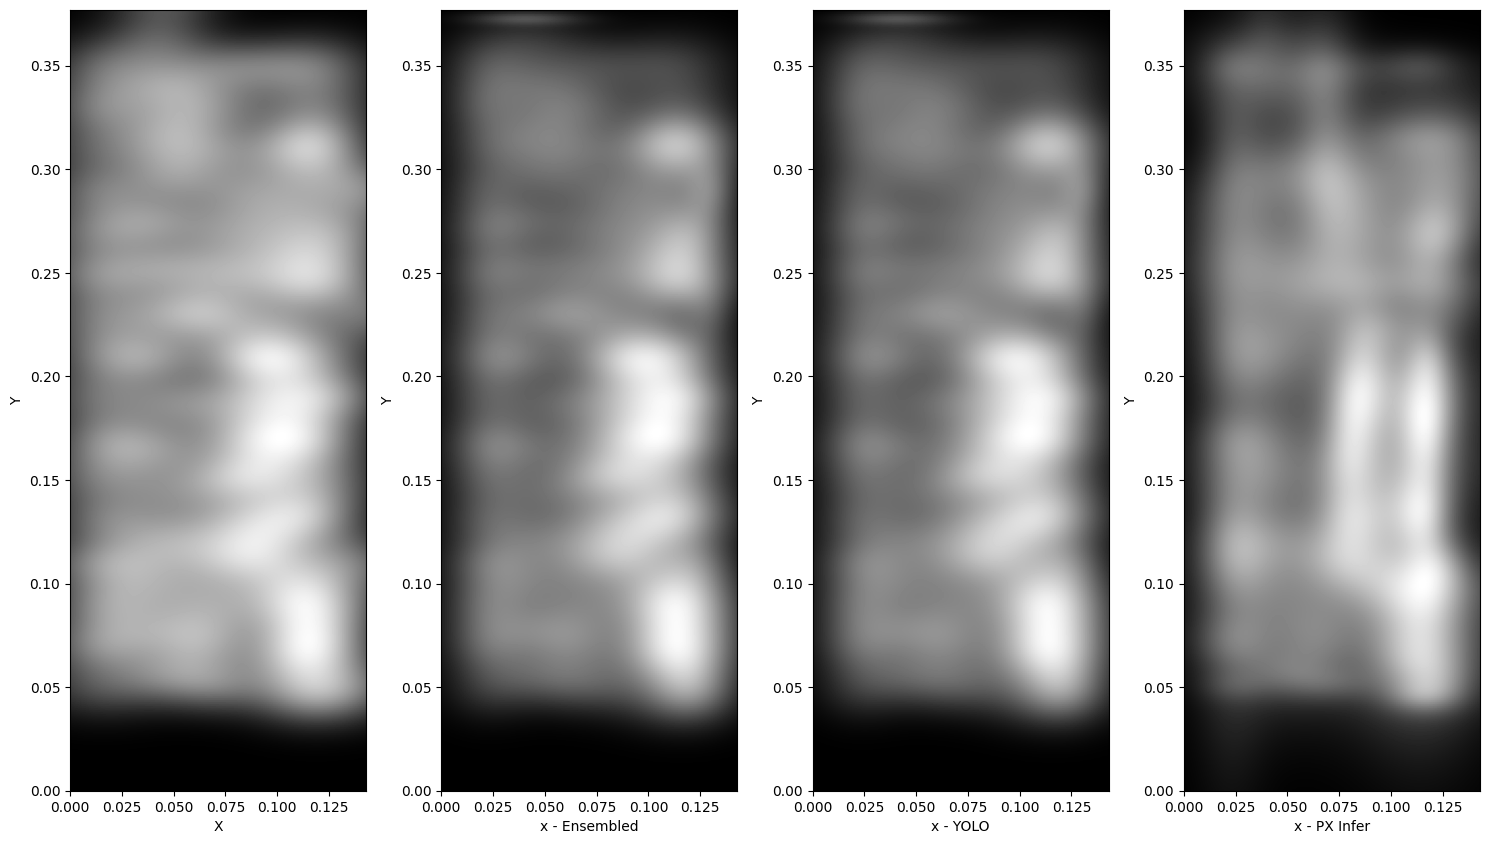

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()